<font size = 8 >**OBJETIVOS** </font>


1.   Processar os dados
2.   Formular hipóteses
3.   Compreender o problema
4.   Determinar uma tarefa
5.   Explorar as relações entre atributos





Os dados são oriundos de duas redes de hotéis em Portugal. O método de coleta de dados e mais informações sobre os dados podem ser encontrados no artigo [Hotel booking demand datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191?ref=pdf_download&fr=RR-2&rr=8746af425ae7622b). Por fim, os dados processados podem ser encontrados na seguinte página do Kaggle [Hotel booking demand](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset/data).

# Configuração do ambiente


In [87]:
!pip install workalendar

In [88]:
from datetime import  date
import holidays
from workalendar.europe import Portugal
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import ks_2samp


In [89]:
sns.set_style("whitegrid")


In [90]:
len(dados)

36275

# Pré processamento inicial

Resumo do que foi feito:

* Leitura dos dados
* Ratificação dos tipos de atributos
* Remoção de dados duplicados

In [91]:
dados = pd.read_csv('https://raw.githubusercontent.com/Gabrieldpll/Hotel-Reservations/main/Hotel%20Reservations.csv')

In [92]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [93]:
# É necessário corrigir a codificação de algumas colunas.
dados['required_car_parking_space'] = dados['required_car_parking_space'].astype('object')
dados['repeated_guest'] = dados['repeated_guest'].astype('object')


In [94]:
# Excluimos a coluna de indexador que não será útil para tarefa de classificação
raw_data = dados.copy()
dados.drop(['Booking_ID'],axis = 1 , inplace = True)

In [95]:
# Não há observações nulas
dados.isna().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

In [96]:
# Há observações duplicadas
print(f'Há {dados.duplicated().sum()} observações duplicadas')


Há 10275 observações duplicadas


In [97]:
# É possível filtrar as observações duplicadas,  que pode ser útil no futuro
observacoes_duplicadas = dados[dados.duplicated()]
observacoes_duplicadas.head(5)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
20,2,0,2,2,Meal Plan 1,0,Room_Type 1,99,2017,10,30,Online,0,0,0,65.0,0,Canceled
154,2,0,0,1,Meal Plan 2,0,Room_Type 1,55,2018,4,6,Offline,0,0,0,104.0,0,Not_Canceled
272,2,0,1,2,Meal Plan 2,0,Room_Type 1,161,2018,3,25,Online,0,0,0,130.0,0,Canceled
301,1,0,0,2,Meal Plan 1,0,Room_Type 1,188,2018,6,15,Online,0,0,0,130.0,0,Canceled
319,2,0,0,2,Meal Plan 2,0,Room_Type 1,320,2018,8,18,Online,0,0,0,115.0,1,Canceled


Vamos argumentar que os dados duplicados são, na verdade, algum erro no momento de realizar ou armazenar a reserva no sistema de dados

In [98]:
# Uma função para achar as observações duplicadadas
def find_duplicated(index,data):
  return data[data.eq(data.loc[index,:], axis = 1).all(axis  = 1)]

In [99]:
#Por exemplo, buscar por observações iguais aquelas correspondente ao index 20
find_duplicated(20,dados)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
18,2,0,2,2,Meal Plan 1,0,Room_Type 1,99,2017,10,30,Online,0,0,0,65.0,0,Canceled
20,2,0,2,2,Meal Plan 1,0,Room_Type 1,99,2017,10,30,Online,0,0,0,65.0,0,Canceled
2142,2,0,2,2,Meal Plan 1,0,Room_Type 1,99,2017,10,30,Online,0,0,0,65.0,0,Canceled
3404,2,0,2,2,Meal Plan 1,0,Room_Type 1,99,2017,10,30,Online,0,0,0,65.0,0,Canceled
3775,2,0,2,2,Meal Plan 1,0,Room_Type 1,99,2017,10,30,Online,0,0,0,65.0,0,Canceled
3843,2,0,2,2,Meal Plan 1,0,Room_Type 1,99,2017,10,30,Online,0,0,0,65.0,0,Canceled


In [100]:
# Verifica se as obervações duplicadas foram armazenadas como reservas com identificadores diferentes
raw_data.filter(find_duplicated(20,dados).index , axis = 0)['Booking_ID']

18      INN00019
20      INN00021
2142    INN02143
3404    INN03405
3775    INN03776
3843    INN03844
Name: Booking_ID, dtype: object

Reservas duplicadas recebem identificadores(`Booking_ID`) diferentes. Isso significa que a mesma informação é repetida várias vezes, mesmo que isso possa ser resultado de algum erro no armazenamento ou processamento das reservas. Por isso, fazemos as seguintes ponderações:

In [63]:
dados['hotel']

KeyError: 'hotel'

* As observações duplicadas correspondem a 28% do conjunto de dados.
* Na análise preditiva, pode-se considerar remover as observações duplicadas, principalmente devido ao vazamento de dados.
* **Prosseguiremos a análise removendo as observações duplicadas, entendendo que as reservas duplicadas são oriundas de algum inconveniente no momento de realizar a reserva. Essa decisão deve ser informada ao time de analistas**
* Se as observações duplicadas fossem considerdas, haveria a necessidade de adotar algum modelo que suporta repetição de observações. Nesse caso, os modelo  de regressão logística e os modelos generalizados, na sua forma mais simples, não são adequados, pois supõem independência das observações

In [101]:
#https://copyprogramming.com/howto/add-column-to-dataframe-that-has-each-row-s-duplicate-count-value-takes-too-long
dados['is_duplicated'] = dados.duplicated(keep = False) # Flag para dados duplicados.
dados['duplicated_count'] =  dados.groupby(dados.columns.to_list(), sort=False).transform('size') - 1

In [102]:
dados.drop_duplicates(inplace = True , ignore_index = False ) # ignore_index = False ( preservar index , pode ser necessário para consultas)

* Por fim , adicionamos duas colunas - uma indicando se a reserva foi efetuada mais de uma vez  e outra indicando a quantidade de vezes que isso aconteceu

# Explorando as variáveis temporais

## Criando uma coluna do tipo datetime

In [103]:

def transofrm_data(x):
  dia = x['arrival_date']
  mes = x['arrival_month']
  ano = x['arrival_year']
  try:
    data = date(ano,mes,dia)
    return(data)
  except:
    print(f'data errada : {dia} / {mes} / {ano} ')
    return(date(2018,2,28)) #OBS: Má prática; o ideal é criar uma flag e tratar isso posteriormente. Também é necessário avisar o time de engenharia de dados
dados['data'] =  pd.to_datetime(
                                dados.loc[ :, ['arrival_year','arrival_month','arrival_date']].apply(transofrm_data,axis = 1)
)

data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 29 / 2 / 2018 
data errada : 

In [104]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26000 entries, 0 to 36273
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   no_of_adults                          26000 non-null  int64         
 1   no_of_children                        26000 non-null  int64         
 2   no_of_weekend_nights                  26000 non-null  int64         
 3   no_of_week_nights                     26000 non-null  int64         
 4   type_of_meal_plan                     26000 non-null  object        
 5   required_car_parking_space            26000 non-null  object        
 6   room_type_reserved                    26000 non-null  object        
 7   lead_time                             26000 non-null  int64         
 8   arrival_year                          26000 non-null  int64         
 9   arrival_month                         26000 non-null  int64         
 10  arr

In [105]:
print(f"Os dados foram observados em {len(dados['data'].unique())} dias diferentes")

Os dados foram observados em 549 dias diferentes


## Taxa de cancelamento por tempo

Nessa seção processamos a base de dados para que seja possível analisar a taxa de cancelamento ao longo do tempo.

In [106]:
# Um processamento para gerar uma série temporal da taxa de cancelamento.

dados_agrupados_por_tempo =(
  dados
 .groupby(['data', 'booking_status'])
 .size()
 .unstack()
 .fillna(0)
 .assign(Canceled_ratio = lambda x : x['Canceled'] / (x['Canceled'] + x['Not_Canceled']))



)

In [107]:
#  Isso exibe um gráfico interativo da série temporal.
plt.figure(figsize=(13,3.5))
fig = px.line( dados_agrupados_por_tempo, y = 'Canceled_ratio')
fig.show()



<Figure size 1300x350 with 0 Axes>

* De julho de 2017 até agosto, há um pico agressivo na taxa de cancelamento, com vários dias registrando apenas reservas canceladas. Esse comportamento anormal não se repete ao longo da série temporal. Suspeita-se que isso seja em virtude de alguma falha no processo de coleta dos dados ou algum evento que prejudicou a rede de hotéis nesse período.


In [108]:
dados_sem_anomalia = dados_agrupados_por_tempo[dados_agrupados_por_tempo.index > '2017-07-31']

In [109]:
fig = px.line( dados_sem_anomalia, y = 'Canceled_ratio')
fig.show()

 * Ao filtrar o período com suspeita de anomalias, obtemos uma série temporal com "outra cara". Apesar de ser possível realizar essa análise utilizando o zoom do gráfico interativo, a apresentação desse é crucial para evitar conclusões precipitadas sobre a série temporal.

* Ao comparar as séries temporais de setembro de 2017 até dezembro de 2017 com as séries temporais de setembro de 2018 até dezembro de 2018, nota-se um deslocamento 'para cima', indicando uma possível evidência de aumento na taxa de cancelamento nesse período
* Uma decomposição em componentes de tedência e sazonalidade, que pode ser útil para descrever a série temporal.

A decomposição STL será utilizada para explorar os componentes da série temporal. Refere-se ao seguinte link :  https://otexts.com/fpp3/stl.html para mais informações sobre este método. Por ora, é importante saber que  podemos utilizar desse recurso para ajudar a resumir as informações da série temporal.

In [110]:
# Realiza a decompisição(aditiva) da serie temporal
stl = STL(dados_sem_anomalia['Canceled_ratio'] , robust = True, seasonal = 11)
res = stl.fit()


Os resíduos, de forma informal, captam as informações não modeladas. Para que a decomposição seja útil, é importante que não haja autocorrelação entre os resíduos, o que indica que o modelo capturou grande parte da variação temporal.

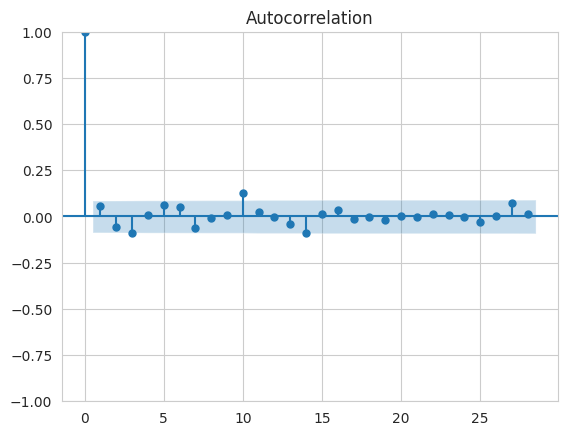

In [111]:
sm.graphics.tsa.plot_acf(res.resid)
plt.show()

Os resíduos também podem ser utilizados para identificar candidatos a outliers. Aquelas observações que têm um "resíduo muito alto" distoam do padrão esperado e podem ser consideradas candidatos a outliers. Note que "resíduo muito alto" é subjetivo e implica em alguma forma de medir a distância entre o resíduo e o esperado; aqui utilizamos a forma mais simples, o escore Z.



Por simplicidade, adotamos "outlier" no lugar de "candidato a outlier". Evidentemente, determinar se um ponto é outlier requer conhecimento prévio sobre a série temporal a ser estudada, por exemplo, conhecimento da literatura ou consulta a especialistas e análise mais profunda dos métodos de detecção de outliers

In [112]:
# Uma sugestão é utilizar os resíduos como um modo de detectar outilers ,utilizando a estatística z
residuos  = res.resid.to_frame()
residuos['outlier'] = ( residuos['resid'] - np.mean(residuos['resid']) ) / np.std(residuos['resid']) > 3
residuos['observed'] = res.observed
fig = px.scatter(residuos, y='resid', color = 'outlier' )
fig.show()

In [113]:
outiler_filtrado = residuos[residuos['outlier'] == True]['observed']
fig = px.line(residuos, y='observed')
fig.add_trace(go.Scatter(x=outiler_filtrado.index, y=outiler_filtrado , mode = 'markers',
                         marker_symbol = 'star',
                         marker_size = 10,
                         name  = 'Potencial Outiler'))
fig.show()


* O gráfico interativo permite dar zoom nos outliers. De fato, esses pontos representam momentos em que houve uma mudança abrupta na taxa de cancelamento.
* Em uma futura análise, deve-se dedicar tempo na escolha dos parâmetros do STL.


In [114]:
fig = px.line(res.trend)
fig.show()

* Esse gráfico permite visualizar padrões de tendência nas séries temporais. Por exemplo, observa-se um padrão de decrescimento de agosto de 2017 até janeiro de 2018. Se for de interesse do analista, o componente de tendência pode ser modelado de outras formas, considerando modelos ainda mais flexíveis.

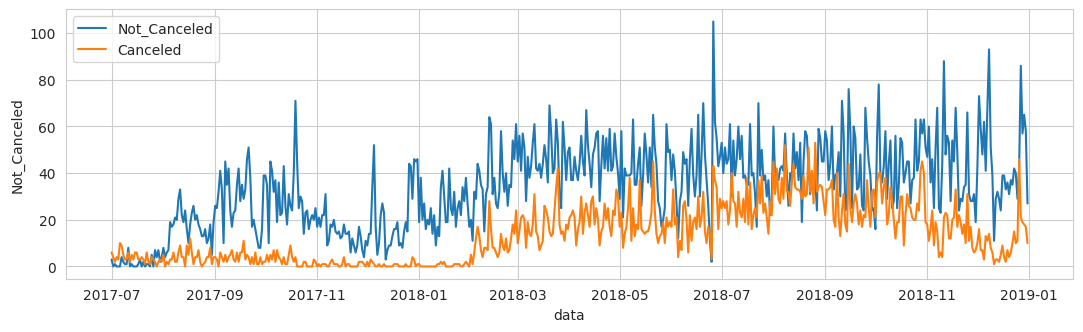

In [115]:
plt.figure(figsize=(13,3.5))

# Supondo que 'data' seja uma coluna do DataFrame
sns.lineplot(data=dados_agrupados_por_tempo, x='data', y='Not_Canceled', label='Not_Canceled')
sns.lineplot(data=dados_agrupados_por_tempo, x='data', y='Canceled', label='Canceled')

# Adiciona a legenda
plt.legend()

plt.show()

 Por fim, apresentamos as séries temporais coloridas por cancelamento. Ao observar este gráfico, podemos formular as seguintes hipóteses:
- Quão semelhantes são as séries temporais?
- As séries temporais têm o mesmo padrão de tendência e/ou sazonalidade?

Outras séries temporais podem ser geradas utilizando este banco de dados, por meio de procedimentos semelhantes aos apresentados.
Isso inclui uma variedade de séries temporais, cada uma com características distintas.
Como esse não é o objetivo primário do trabalho, continuaremos apresentando essas ideias como protótipos para projetos futuros.


## Transformações da variável temporal (Feriados e trimestre)

### Trimestre

In [116]:
def transforma_trimeste(x):
  if x in [1,2,3]:
    return 'primeiro_trimestre'
  elif x in [4,5,6]:
    return 'terceiro_trimestre'
  elif x in [7,8,9]:
    return 'terceiro_trimestre'
  elif x in [10,11,12]:
    return 'quarto_trimestre'

dados['Trimestre'] = dados['arrival_month'].map(transforma_trimeste)

### Feriados


In [117]:
dados['arrival_year'].unique()

array([2017, 2018])

In [118]:
feriados = holidays.Portugal(years=[2017, 2018])

In [119]:
dados['feriado'] = dados['data'].apply(lambda x : 1 if x in feriados else  0 )

In [120]:
# from google.colab import files
# dados.to_csv('Hotel_Reservations_feature_engineering.csv', encoding = 'utf-8-sig')
# files.download('Hotel_Reservations_feature_engineering.csv')

## Análise do preço do quarto de acordo com o mês em que a reserva foi feita

Uma pergunta natural a ser feita é: Há diferença no preço de um quarto de acordo com o mês em que foi feita a reserva?

<Axes: xlabel='arrival_month', ylabel='avg_price_per_room'>

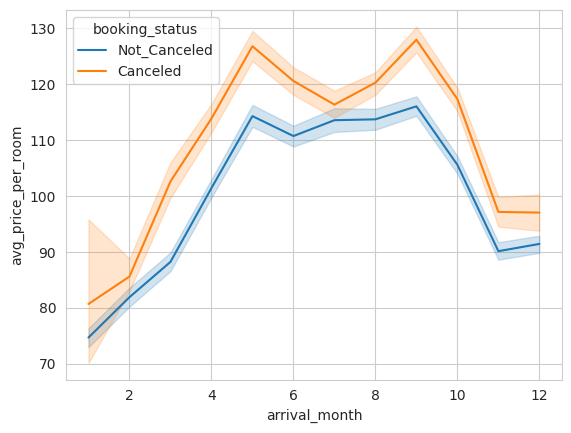

In [121]:
sns.lineplot(x="arrival_month", y="avg_price_per_room",  hue = "booking_status",data= dados)

* Note que a curva dos clientes que cancelaram a reserva está, em geral, acima daqueles que não cancelaram a reserva, para todos os meses.
* Há um padrão sazonal de crescimento nos primeiros semestres, estabilização nos meses do meio do ano e decrescimento nos meses do final do ano.

# Análise exploratória

## Atributos qualitativos nominais


* Reduzimos o número de categorias de alguns atributos.
* Fornecemos uma medida de associação entre as variáveis qualitativas nominais e a variável alvo.
* Analisamos as tabelas de contingência.


### Medida de associação

In [140]:
nominais = ['type_of_meal_plan' , 'required_car_parking_space' , 'room_type_reserved' ,'is_duplicated' ,'market_segment_type', 'repeated_guest', 'feriado']
data_frame_nominal = dados.filter(nominais)
target = dados['booking_status']

In [141]:
def MI(row,column):
  I = mutual_info_score(dados[row], dados[column])
  return I

In [142]:
dict_nominal = {variavel : MI('booking_status',variavel).round(4) for variavel in nominais}

In [143]:
pd.Series(dict_nominal).sort_values(ascending = False)

market_segment_type           0.0289
repeated_guest                0.0097
required_car_parking_space    0.0046
room_type_reserved            0.0035
type_of_meal_plan             0.0013
is_duplicated                 0.0007
feriado                       0.0001
dtype: float64

A informação mútua mede a dependência entre duas variáveis aleatórias. Informalmente, para o nosso problema, ela quantifica o ganho de informação sobre o "cancelamento da reserva" ao conhecer um dos atributos da tabela acima.

De posse da medida de associação, o próximo passo é buscar compreender essa associação mais profundamente, o que será feito via análise  das tabelas de contigências.


### Análise de tabelas de contingência

In [144]:
pd.crosstab(dados['booking_status'] , dados['repeated_guest'],margins = True, normalize = 'index').round(3)*100

# Plano de fidelidade

repeated_guest,0,1
booking_status,,
Canceled,99.9,0.1
Not_Canceled,95.5,4.5
All,96.7,3.3


Através da tabela de contingência acima, normalizada por linhas, observa-se que a maioria dos clientes na base de dados não são reincidentes. No entanto, a proporção de clientes reincidentes que não cancelaram a reserva é  maior (4,5%) em comparação com aqueles que são reincidentes e cancelaram (0,1%).

In [145]:
pd.crosstab(dados['booking_status'] , dados['required_car_parking_space'],margins = True, normalize = 'index').round(3)*100


required_car_parking_space,0,1
booking_status,,
Canceled,98.5,1.5
Not_Canceled,94.7,5.3
All,95.8,4.2


Observa-se uma diferença nas proporções da tabela de contingência. Dentre os clientes que cancelaram, 5.3% requeriram estacionamento, enquanto aqueles que cancelaram apenas 1.5% requeriram.


In [146]:
pd.crosstab(dados['booking_status'] , dados['market_segment_type'],margins = True, normalize = 'index').round(3)*100


market_segment_type,Aviation,Complementary,Corporate,Offline,Online
booking_status,,,,,
Canceled,0.3,0.0,1.7,6.6,91.4
Not_Canceled,0.4,1.9,6.9,19.5,71.2
All,0.4,1.4,5.4,15.8,77.0


In [147]:
pd.crosstab(dados['booking_status'] , dados['market_segment_type'],margins = True)

market_segment_type,Aviation,Complementary,Corporate,Offline,Online,All
booking_status,,,,,,
Canceled,23,0,130,488,6801,7442
Not_Canceled,77,357,1282,3624,13218,18558
All,100,357,1412,4112,20019,26000


* Observa-se diferenças nas proporções, principalmente na categoria **"Online" e "offline"**.
* A categoria complementar não apresenta exemplos de cancelamentos. Se modelos estatísticos forem utilizados, isso deve ser considerado devido ao problema da separação total.
* Esta tabela pode ser útil para justificar alguma campanha visando reverter os cancelamentos feitos via reserva online.


In [148]:
pd.crosstab(dados['booking_status'] , dados['type_of_meal_plan'],margins = True, normalize = 'index').round(3)*100

type_of_meal_plan,Meal Plan 1,Meal Plan 2,Meal Plan 3,Not Selected
booking_status,,,,
Canceled,75.5,5.7,0.0,18.8
Not_Canceled,79.6,3.8,0.0,16.5
All,78.5,4.4,0.0,17.2


In [150]:
pd.crosstab(dados['booking_status'] , dados['type_of_meal_plan'],margins = True)

type_of_meal_plan,Meal Plan 1,Meal Plan 2,Meal Plan 3,Not Selected,All
booking_status,,,,,
Canceled,5617,424,1,1400,7442
Not_Canceled,14781,710,4,3063,18558
All,20398,1134,5,4463,26000


Observa-se diferenças nas proporções entre as categorias "meal plan 1" e "meal plan 2". Como a categoria "meal plan 3" possui apenas 5 observações, ela será agrupada em uma nova categoria: "meal plan 2 ou 3".

In [151]:
def agrupar_type_of_meal_plan(x):

  if x in ['Meal Plan 2', 'Meal Plan 3']:
    return 'Meal Plan 2 or 3'
  else:
    return x
dados.loc[: ,'type_of_meal_plan'] = dados['type_of_meal_plan'].apply(agrupar_type_of_meal_plan)

In [152]:
pd.crosstab(dados['booking_status'] , dados['feriado'],margins = True, normalize = 'index').round(3)*100

feriado,0,1
booking_status,,
Canceled,96.8,3.2
Not_Canceled,96.3,3.7
All,96.4,3.6


Notemos que a maioria das reservas não são feitas em feriados. Além disso, as proporções da tabela são próximas

## Atributos númericos contínuos

In [153]:
def get_plots_continua(variavel):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    sns.violinplot(data=dados, x="booking_status", y=variavel, ax=ax1)
    ax1.set_title("Violin Plot")

    sns.kdeplot(data=dados, hue="booking_status", x=variavel, fill=True, ax=ax2)
    ax2.set_title("KDE Plot")

    sns.ecdfplot(data=dados, hue="booking_status", x=variavel, ax=ax3)
    ax3.set_title("ECDF Plot")
    plt.tight_layout()
    plt.show()

In [154]:
def get_ks(var):
  data1 = dados.loc[dados['booking_status'] == 'Not_Canceled' , [var]].to_numpy().ravel()
  data2 = dados.loc[dados['booking_status'] == 'Canceled' , [var]].to_numpy().ravel()
  return ks_2samp(data1, data2)[0]


In [155]:
def resumo_continua(coluna):
  resumo =  dados.loc[:, ['booking_status', coluna]].groupby('booking_status').agg(['mean', 'std', 'min',lambda x : x.quantile(0.25) , lambda x :  x.quantile(0.5) , lambda x : x.quantile(0.75)  ,'max', 'skew' , lambda x : x.kurtosis()])
  resumo.columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis(Fisher)']

  return resumo

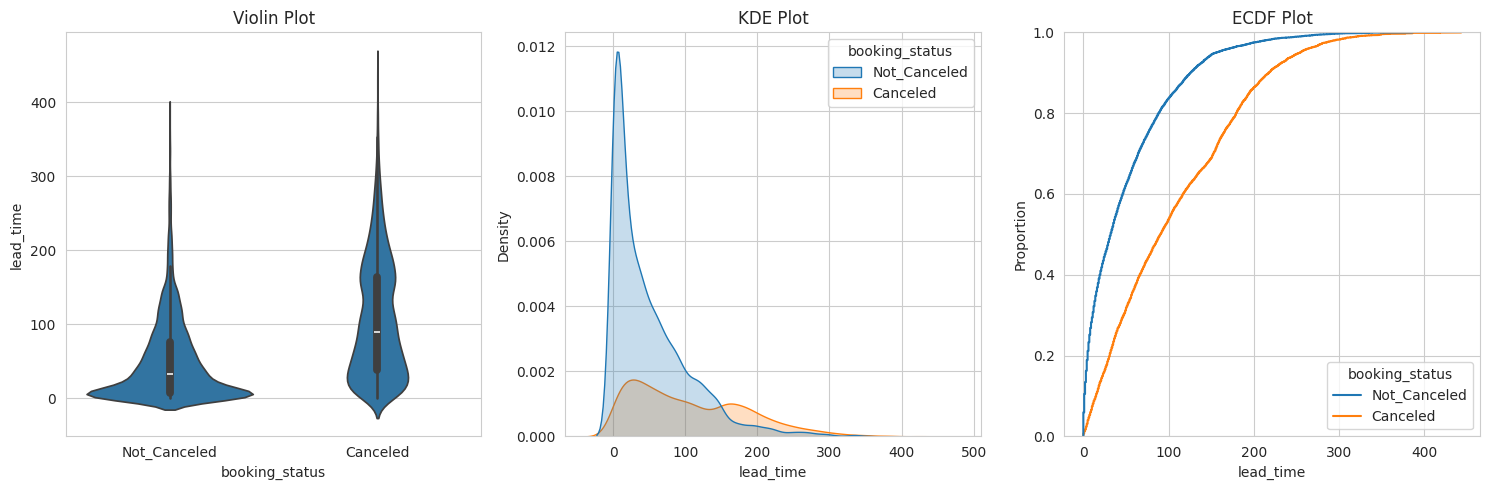

In [156]:
get_plots_continua("lead_time")

In [157]:
resumo_continua('lead_time')

,mean,std,min,25%,50%,75%,max,skewness,kurtosis(Fisher)
booking_status,,,,,,,,,
Canceled,106.697393,80.386334,0,38.0,90.0,164.0,443,0.742223,0.005316
Not_Canceled,50.314258,55.618378,0,7.0,32.0,76.0,386,1.728443,3.700856


In [158]:
get_ks('lead_time').round(3)

0.311

* Por meio do gráfico do violino e também com auxílio das desnsidades estimadas, é possível notar as diferenças nas distribuições do tempo de espera dado o cancelamento ou não da reserva. Grande parte da massa da distribuição das reservas não canceladas está concentrada em tempos de espera menores, enquanto o contrário ocorre com as reservas canceladas. Isso também é evidenciado pela curtose e assimetria, que são maiores para o tempo de espera dado não cancelamento. Por fim, o desvio padrão da distribuição dos cancelados é maior do que o das não canceladas, assim como todas as estatísticas de ordem.
* O terceiro gráfico pode ser utilizado para verificar a dominância estocástica da distribuição do tempo de espera dado cancelamento contra a distribuição do tempo de espera dado não cancelamento (Em outras palavras, a distribuição do tempo de espera das reservas canceladas é maior do que a das não canceladas)
. A estatística KS também é alta, indicando que esse atributo pode ser importante para determinar o cancelamento da reserva.


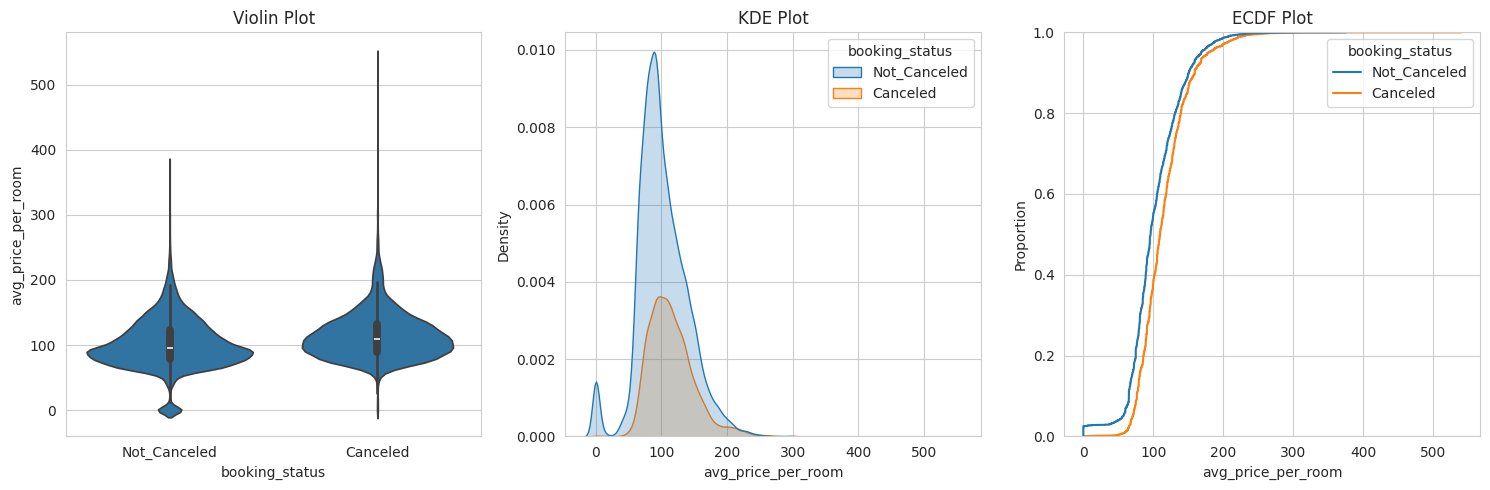

In [159]:
get_plots_continua("avg_price_per_room")

In [160]:
resumo_continua('avg_price_per_room')

,mean,std,min,25%,50%,75%,max,skewness,kurtosis(Fisher)
booking_status,,,,,,,,,
Canceled,115.020099,35.456786,0.0,90.0000,109.65,132.6925,540.0,1.319318,5.082809
Not_Canceled,101.956688,38.170930,0.0,78.8575,96.00,124.0000,375.5,0.416974,1.775522


In [161]:
get_ks('avg_price_per_room').round(3)

0.175

* Note que a média e as estatísticas de ordens da distribuição do preço médio dos quartos são maiores para reservas canceladas.
* Por meio do gráfico de violino e das densidades estimadas, é possível perceber uma diferença no formato das duas distribuições. Isso é evidenciado principalmente pela grande concentração de massa em torno de 0 na distribuição dos não cancelados, o que ocorre quando o preço do quarto é 0, uma possibilidade nesta base de dados devido à utilização de tickets ou outras promoções.
* Por fim, a estatística KS e o gráfico das distribuições empíricas são apresentados. É possível notar a dominância estocástica da distribuição do preço médio do quarto dado cancelamento.


## Atributos númericos discretos

### Associação

In [162]:
from scipy.stats import pointbiserialr, spearmanr

In [163]:
discretos  = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights','no_of_week_nights','no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled','no_of_special_requests']
binary_target = dados['booking_status'].map({'Not_Canceled' :  1 , 'Canceled' : 0})

In [164]:
dict_ordinal_correlation = {variavel : pointbiserialr(binary_target, dados[variavel])[0] for variavel in discretos}

In [165]:
pd.Series(dict_ordinal_correlation)

no_of_adults                           -0.093289
no_of_children                         -0.063468
no_of_weekend_nights                   -0.071949
no_of_week_nights                      -0.126924
no_of_previous_cancellations            0.039412
no_of_previous_bookings_not_canceled    0.064307
no_of_special_requests                  0.257615
dtype: float64

* O número de pedidos especiais destaca-se, apresentando a maior correlação com a variável de cancelamento da reserva. Essa correlação é positiva, indicando que quanto mais pedidos especiais são feitos, tendem a ser mais frequentes nos clientes que não cancelaram.

* O número de noites passadas em dias da semana tem uma correlação negativa (-0.12), sugerindo que os clientes que não cancelaram tendem a passar menos noites no hotel.


### Tableas de contigências e gráficos

A tabela de contigência e o gráfico bump_plot podem ser úteis para visualizar a associação entre uma variável categórica e outra númerica discreta ou categórica ordinal

In [166]:
# Melhorado pelo Google Gemini

def bump_plot(data, var_1, var_2):
  """
  Recebe um conjunto de dados e dois atributos (var_1, var_2).

  Var_1: Variável (Nominal) que será utilizada para criar diferentes linhas no gráfico
  Var_2: Variável (Ordinal) que será utilizada para compor o eixo-x

  Exibe um gráfico do tipo bump_plot entre var_1 e var_2.
  """

  # Cálculo das porcentagens
  porcentagens = (
      pd.crosstab(data[var_1], data[var_2], normalize="index")
      .round(3)
      .stack()
      .reset_index()
  )
  porcentagens.columns = [var_1, var_2, "porcentagem"]

  # Configurando o tamanho da figura
  plt.figure(figsize=(10, 6))

  # Plotando o gráfico
  sns.lineplot(
      x=var_2, y="porcentagem", hue=var_1, marker="o", data=porcentagens
  )

  # Adicionando rótulos e título
  plt.xlabel("Status")
  plt.ylabel("Proporção")
  plt.title(f"Gráfico bump_plot - Proporção por {var_1} e {var_2}")

  # Exibindo o gráfico
  plt.show()


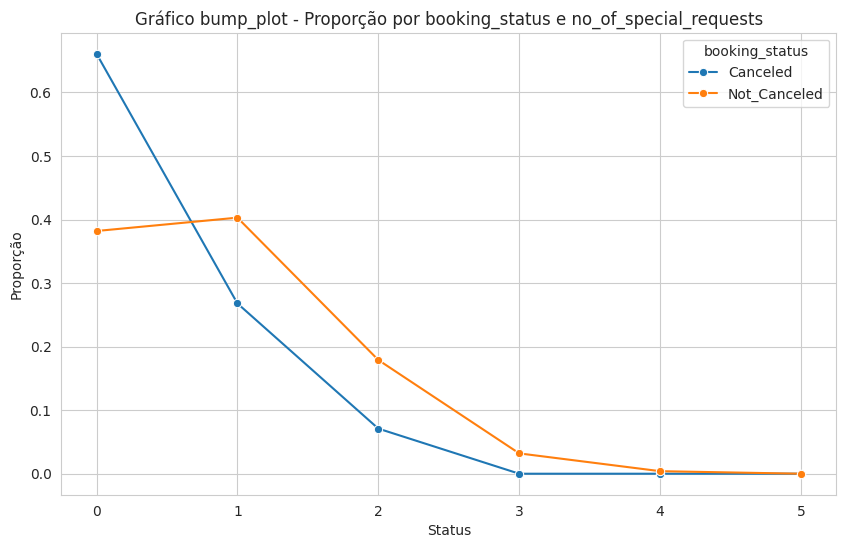

In [167]:
bump_plot(dados,'booking_status','no_of_special_requests')

Este gráfico pode ser utilizado para visualizar a conclusão obtida utilizando o coeficiente de correlação. Isso é :  que mais pedidos especiais são feitos por clientes que não cancelaram a reserva

In [168]:
pd.crosstab(dados['booking_status'] , dados['no_of_children'],margins = True, normalize = 'index').round(3)*100


no_of_children,0,1,2,3,9,10
booking_status,,,,,,
Canceled,87.4,6.6,6.0,0.1,0.0,0.0
Not_Canceled,91.2,5.6,3.2,0.1,0.0,0.0
All,90.1,5.9,4.0,0.1,0.0,0.0


Por último , essas relações podem ser exploradas vias tabela de contingências

## Matriz de correlação


  Utilizamos a matriz de correlações para:
  * Verificar a presença de multicolinearidade
  * Procurar por relações óbvias
  * Motivar o uso de métodos de estatística multivariada (como PCA)


In [175]:
dados_numericos = dados.filter(['no_of_adults', 'no_of_children', 'no_of_weekend_nights','lead_time', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests','duplicated_count'])

corr_matrix  = dados_numericos.corr(method='kendall')

<Axes: >

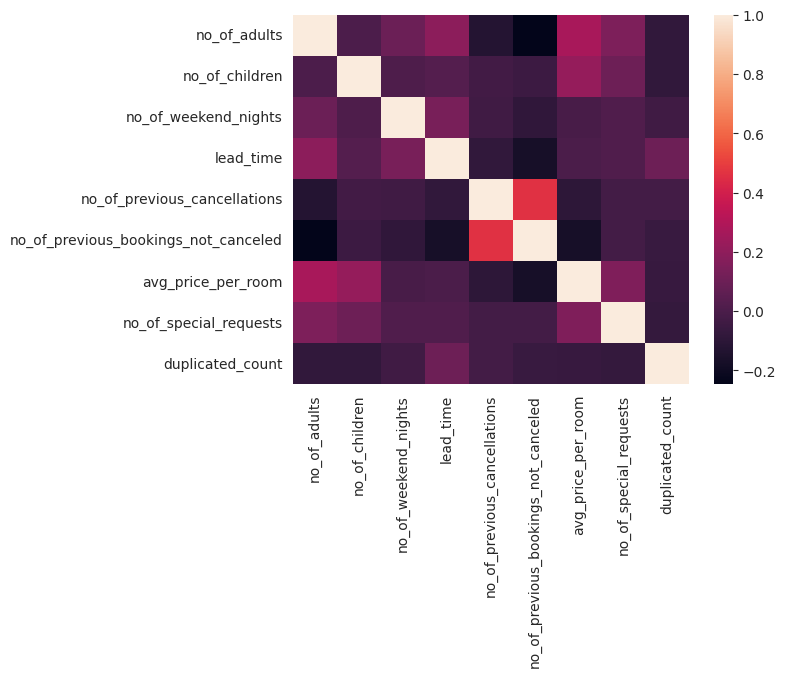

In [176]:
sns.heatmap(corr_matrix,annot=False)



A matriz de correlação é apresentada. Ela pode ser utilziada para explorar a associação entre as variáveis númericas

In [171]:
#https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack() )
index = sol.abs().sort_values(ascending = False).index

In [172]:
pd.DataFrame(sol[index]).head(15)

0
no_of_previous_cancellations         no_of_previous_bookings_not_canceled  0.465988
no_of_adults                         avg_price_per_room                    0.336112
no_of_children                       avg_price_per_room                    0.267441
no_of_adults                         no_of_previous_bookings_not_canceled -0.256163
                                     lead_time                             0.243811
lead_time                            no_of_previous_bookings_not_canceled -0.211087
no_of_previous_bookings_not_canceled avg_price_per_room                   -0.209838
avg_price_per_room                   no_of_special_requests                0.199013
no_of_weekend_nights                 lead_time                             0.177459
no_of_adults                         no_of_special_requests                0.162806
                                     no_of_previous_cancellations         -0.129523
lead_time                            duplicated_count                      0.124088
no_of_previous_cancellations         avg_price_per_room                   -0.122370
no_of_children                       no_of_special_requests                0.107397
no_of_adults                         no_of_weekend_nights                  0.104904

Pode ser útil uma tabela com as maiores correlações (em módulo) entre os atributos. Principalmente, para verificar associações suspeitas, como é o caso da primeira linha da tabela exibida

In [178]:
dados_agrupado_cancelamentos_previos = dados.groupby(['no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled']).size()
dados_agrupados_cancelamentos_previos = (
    dados
    .groupby(['no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled'])
    .size()
    .reset_index()
)
dados_agrupados_cancelamentos_previos.columns = ['no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled','Observations']


In [180]:
fig = px.scatter(dados_agrupados_cancelamentos_previos,y = 'no_of_previous_cancellations', x =  'no_of_previous_bookings_not_canceled' , color = 'Observations')
fig.show()


A correlação entre esses dois atributos ocorre principalmente porque o par (0,0) é o mais frequente na base de dados. Poderíamos excluir esse atributo para evitar redundância

* Os atributos numéricos estão correlacionados. Em geral, essa correlação não é alta, exceto para o número de reservas prévias não canceladas e o número prévio de reservas canceladas. Essa correlação é investigada posteriormente, utilizando um gráfico de pontos com uma barra de calor que indica o número de observações de cada ponto no gráfico. Na base de dados geral, nota-se que essa correlação é principalmente devida ao ponto (0,0), presente em 25.148 observações (96% da base de dados, veja ponto em amarelo nos gráficos).

* Um passo futuro é aproveitar a estrutura de correlação para extrair features, por meio do PCA, por exemplo.


# Definição de tarefa

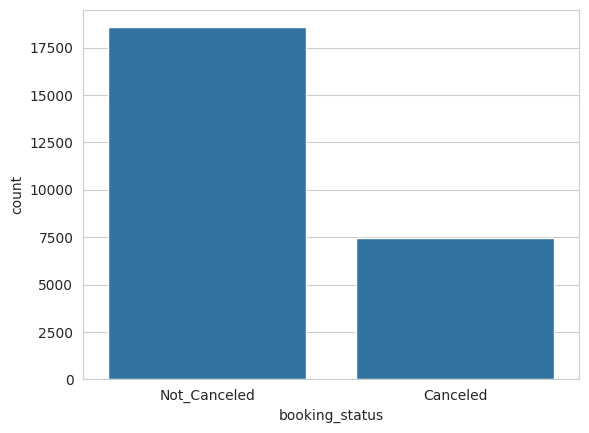

In [181]:
sns.countplot(data = dados , x = 'booking_status')
plt.show()

In [182]:
(dados['booking_status'].value_counts()/len(dados)).round(3)*100

booking_status
Not_Canceled    71.4
Canceled        28.6
Name: count, dtype: float64

In [183]:
print(f"Prejuízo gerado cancelamento {dados[dados['booking_status']== 'Canceled']['avg_price_per_room'].sum().round(2)}")

Prejuízo gerado cancelamento 855979.58


* Podemos definir uma tarefa do tipo classificação binária, que consiste em classificar uma reserva como cancelada ou não cancelada, utilizando os atributos da base de dados processada.

* Em termos de negócios, prever se o cliente irá cancelar pode oferecer vantagens, como melhor planejamento das reservas ou para futuras ações destinadas a reverter essas reservas canceladas, evitando assim prejuízos significativos, como os observados anteriormente.


In [185]:
from google.colab import files
dados.to_csv('Hotel_Reservations_feature_engineering.csv', encoding = 'utf-8-sig', index = False)
files.download('Hotel_Reservations_feature_engineering.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Links úteis e referências

* [1]  https://www.ibm.com/docs/en/spss-statistics/25.0.0?topic=crosstabs-statistics
* [2] https://www.statisticshowto.com/rank-biserial-correlation/
* [3] https://en.wikipedia.org/wiki/Mutual_information
* [4] https://journals.sagepub.com/doi/pdf/10.1177/8756479308317006
* [5] https://en.wikipedia.org/wiki/Ordinal_data


Chatbots foram utilizados apenas para revisão ortográfica (ChatGPT e Gemini). A geração de código, quando realizada por aqueles , é devidamente citada ao longo do código. É importante frisar que este recurso não é utilizado para interpretar dados ou resultados, principalmente devido à falta de rigor científico e ausência de referências confiáveis.